In [1]:
# set up imports
import numpy as np
import torch
import statsmodels.nonparametric.smoothers_lowess
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from behavior_model_fitting.helpers.policy import softmax, pick_action 
from behavior_model_fitting.tasks.BernoulliBandit import BernoulliBandit

## samples from many subject

In [10]:
nsubjects = 10

In [42]:
# task params
prob = [0.9]
ntrials = 1000

task = BernoulliBandit(seed=0, probs=prob)
outcomes = task.sample(num_episodes=ntrials)

In [43]:
# suject params
betas = np.random.uniform(0.01, 10, nsubjects)
lrs = np.random.uniform(0.001, 0.1, nsubjects)
Qs = torch.as_tensor([0.5, 0.5]) #np.repeat(torch.as_tensor([0.5, 0.5]).reshape(1, -1), nsubjects, axis=0) 

In [44]:
actions = np.zeros((nsubjects, ntrials))
rewards = np.zeros((nsubjects, ntrials))
corrects = np.zeros((nsubjects, ntrials))

In [45]:
def generate_samples_from_participant(n_trials, q, beta, lr, outcomes):
    action = np.zeros(ntrials)
    reward = np.zeros(ntrials)
    correct = np.zeros(ntrials)

    # generate samples for a given subject
    for trial in range(ntrials):
        probs = softmax(q, beta)
        action[trial] = pick_action(probs)
        a_t = action[trial].astype('int')
        reward[trial] = outcomes[trial][a_t]
        correct[trial] = (reward[trial] == outcomes.max().data.numpy())
        q[a_t] = q[a_t] + lr*(reward[trial]-q[a_t])
        
    return action, reward, correct

In [46]:
df = pd.DataFrame(columns=['actions', 'rewards', 'corrects', 'true_beta', 'true_lr', 'true_Qinit', 'outcomes'], index=np.arange(nsubjects))
for subj in range(nsubjects):
    Qinit = Qs.clone().detach()
    actions[subj], rewards[subj], corrects[subj] = generate_samples_from_participant(ntrials, Qinit, betas[subj], lrs[subj], outcomes) 
    df.loc[subj] = pd.Series({'actions':actions[subj], 'rewards':rewards[subj], 'corrects':corrects[subj], 'true_beta': np.asarray(betas[subj]), 
                              'true_lr':np.asarray(lrs[subj]), 'true_Qinit': Qs.data.numpy(), 'outcomes':np.asarray(outcomes.data.numpy())})

In [49]:
df.to_pickle('../data/BernoulliBanditData.pickel')

## single subject

In [4]:
# task params
prob = [0.9]
ntrials = 1000

# init
action = np.zeros(ntrials)
reward = np.zeros(ntrials)
correct = np.zeros(ntrials)
task = BernoulliBandit(seed=0, probs=prob)
outcomes = task.sample(num_episodes=ntrials)

In [13]:
# per suject params
beta = 10 # 10, 0.01
lr = 0.0001 #0.1, 0.001
q = torch.as_tensor([0.5, 0.5]) # initilize q-value (handedness)

In [14]:
# generate samples for a given subject
for trial in range(ntrials):
    probs = softmax(q, beta)
    action[trial] = pick_action(probs)
    a_t = action[trial].astype('int')
    reward[trial] = outcomes[trial][a_t]
    correct[trial] = (reward[trial] == outcomes.max().data.numpy())
    q[a_t] = q[a_t] + lr*(reward[trial]-q[a_t])

## visualize for one subject

In [15]:
blocksize=10
nblocks=int(ntrials/blocksize)
block_reward=np.zeros(nblocks)
for i in range(nblocks):
    block_trials=np.arange(i*blocksize,(i+1)*blocksize)
    block_reward[i]=np.mean(correct[block_trials]==1)

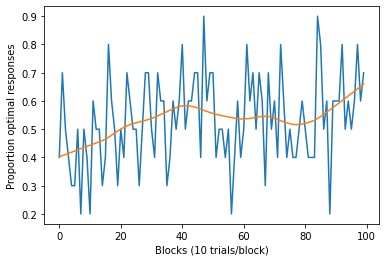

In [16]:
plt.plot(block_reward)
smooth=statsmodels.nonparametric.smoothers_lowess.lowess(block_reward,np.arange(block_reward.shape[0]),frac=0.33)
plt.plot(smooth[:,1])
plt.xlabel('Blocks (%d trials/block)'%blocksize)
plt.ylabel('Proportion optimal responses')
plt.show()